In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from ast import literal_eval
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *
from imageUtils import *

In [2]:
device = torch.device("cuda")
print(device)

cuda


In [3]:
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

# Load Dataset

Total class count = 340
Train dataset loaded from train_simplified_modifed
30000 rows each file for each class

Validation dataset loaded from valid_simplied_modified
10000 rows each file for each class

Test dataset loaded from test_simplified_modified
10000 rows each file for each class

In [4]:
def read_one_df_file(df_file):
    name = df_file.split('/')[-1].replace('.csv','')
    df = pd.read_csv(df_file)
    return df

In [5]:
CLASS_NAME=\
['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'airplane', 'alarm_clock', 'ambulance', 'angel',
 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn',
 'baseball', 'baseball_bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee',
 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book',
 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom',
 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel',
 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan',
 'cell_phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup',
 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship',
 'cup', 'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dragon', 'dresser',
 'drill', 'drums', 'duck', 'dumbbell', 'ear', 'elbow', 'elephant', 'envelope', 'eraser', 'eye', 'eyeglasses',
 'face', 'fan', 'feather', 'fence', 'finger', 'fire_hydrant', 'fireplace', 'firetruck', 'fish', 'flamingo',
 'flashlight', 'flip_flops', 'floor_lamp', 'flower', 'flying_saucer', 'foot', 'fork', 'frog', 'frying_pan',
 'garden', 'garden_hose', 'giraffe', 'goatee', 'golf_club', 'grapes', 'grass', 'guitar', 'hamburger',
 'hammer', 'hand', 'harp', 'hat', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hexagon', 'hockey_puck',
 'hockey_stick', 'horse', 'hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house', 'house_plant',
 'hurricane', 'ice_cream', 'jacket', 'jail', 'kangaroo', 'key', 'keyboard', 'knee', 'ladder', 'lantern', 'laptop',
 'leaf', 'leg', 'light_bulb', 'lighthouse', 'lightning', 'line', 'lion', 'lipstick', 'lobster', 'lollipop', 'mailbox',
 'map', 'marker', 'matches', 'megaphone', 'mermaid', 'microphone', 'microwave', 'monkey', 'moon', 'mosquito',
 'motorbike', 'mountain', 'mouse', 'moustache', 'mouth', 'mug', 'mushroom', 'nail', 'necklace', 'nose', 'ocean',
 'octagon', 'octopus', 'onion', 'oven', 'owl', 'paint_can', 'paintbrush', 'palm_tree', 'panda', 'pants',
 'paper_clip', 'parachute', 'parrot', 'passport', 'peanut', 'pear', 'peas', 'pencil', 'penguin', 'piano',
 'pickup_truck', 'picture_frame', 'pig', 'pillow', 'pineapple', 'pizza', 'pliers', 'police_car', 'pond',
 'pool', 'popsicle', 'postcard', 'potato', 'power_outlet', 'purse', 'rabbit', 'raccoon', 'radio', 'rain',
 'rainbow', 'rake', 'remote_control', 'rhinoceros', 'river', 'roller_coaster', 'rollerskates', 'sailboat',
 'sandwich', 'saw', 'saxophone', 'school_bus', 'scissors', 'scorpion', 'screwdriver', 'sea_turtle', 'see_saw',
 'shark', 'sheep', 'shoe', 'shorts', 'shovel', 'sink', 'skateboard', 'skull', 'skyscraper', 'sleeping_bag',
 'smiley_face', 'snail', 'snake', 'snorkel', 'snowflake', 'snowman', 'soccer_ball', 'sock', 'speedboat',
 'spider', 'spoon', 'spreadsheet', 'square', 'squiggle', 'squirrel', 'stairs', 'star', 'steak', 'stereo',
 'stethoscope', 'stitches', 'stop_sign', 'stove', 'strawberry', 'streetlight', 'string_bean', 'submarine',
 'suitcase', 'sun', 'swan', 'sweater', 'swing_set', 'sword', 't-shirt', 'table', 'teapot', 'teddy-bear',
 'telephone', 'television', 'tennis_racquet', 'tent', 'tiger', 'toaster', 'toe', 'toilet', 'tooth',
 'toothbrush', 'toothpaste', 'tornado', 'tractor', 'traffic_light', 'train', 'tree', 'triangle',
 'trombone', 'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 'washing_machine',
 'watermelon', 'waterslide', 'whale', 'wheel', 'windmill', 'wine_bottle', 'wine_glass', 'wristwatch',
 'yoga', 'zebra', 'zigzag']


class DoodleDataset(Dataset):

    def __init__(self, mode, augment = null_image_augment):
        super(DoodleDataset, self).__init__()
        self.mode       = mode
        self.augment =augment

        self.df     = []
        self.id     = []

        if mode=='train':
            global TRAIN_DF
            TRAIN_DF=[]
            # countrycode, drawing, key_id, recognized, timestamp, word

            if TRAIN_DF == []:
                df_files =['train_simplified_modified/%s.csv'%(name.replace('_', ' ')) for name in CLASS_NAME]

                TRAIN_DF = [read_one_df_file(f) for f in df_files]

            self.df = TRAIN_DF

            for l,name in enumerate(CLASS_NAME):
                name = name.replace('_', ' ')

                df = TRAIN_DF[l]
                #key_id = np.loadtxt(DATA_DIR + '/split/%s/%s'%(split,name), np.int64)
                key_id = df['key_id']
                label = np.full(len(key_id),l,np.int64)
                drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
                self.id.append(
                    np.vstack([label, drawing_id, key_id]).T
                )
            self.id = np.concatenate(self.id)
            print('')
            
        if mode=='valid':
            TRAIN_DF=[]
            # countrycode, drawing, key_id, recognized, timestamp, word

            if TRAIN_DF == []:
                df_files =['valid_simplified_modified/%s.csv'%(name.replace('_', ' ')) for name in CLASS_NAME]

                TRAIN_DF = [read_one_df_file(f) for f in df_files]

            self.df = TRAIN_DF

            for l,name in enumerate(CLASS_NAME):
                name = name.replace('_', ' ')

                df = TRAIN_DF[l]
                #key_id = np.loadtxt(DATA_DIR + '/split/%s/%s'%(split,name), np.int64)
                key_id = df['key_id']
                label = np.full(len(key_id),l,np.int64)
                drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
                self.id.append(
                    np.vstack([label, drawing_id, key_id]).T
                )
            self.id = np.concatenate(self.id)
            print('')
            
        if mode=='test_local':
            TRAIN_DF=[]
            # countrycode, drawing, key_id, recognized, timestamp, word

            if TRAIN_DF == []:
                df_files =['test_simplified_modified/%s.csv'%(name.replace('_', ' ')) for name in CLASS_NAME]

                TRAIN_DF = [read_one_df_file(f) for f in df_files]

            self.df = TRAIN_DF

            for l,name in enumerate(CLASS_NAME):
                name = name.replace('_', ' ')

                df = TRAIN_DF[l]
                #key_id = np.loadtxt(DATA_DIR + '/split/%s/%s'%(split,name), np.int64)
                key_id = df['key_id']
                label = np.full(len(key_id),l,np.int64)
                drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
                self.id.append(
                    np.vstack([label, drawing_id, key_id]).T
                )
            self.id = np.concatenate(self.id)
            print('')

        if mode=='test':
            global TEST_DF
            TEST_DF=[]
            # key_id, countrycode, drawing

            if TEST_DF == []:
                TEST_DF = pd.read_csv('test_simplified/test_simplified.csv')
                self.id = np.arange(0,len(TEST_DF))

            self.df = TEST_DF


    def __str__(self):
        N = len(self.id)
        string = ''\
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, index):


        if self.mode=='train':
            label, drawing_id, key_id = self.id[index]
            drawing = self.df[label]['drawing'][drawing_id]
            drawing = eval(drawing)
        
        if self.mode=='valid':
            label, drawing_id, key_id = self.id[index]
            drawing = self.df[label]['drawing'][drawing_id]
            drawing = eval(drawing)
            
        if self.mode=='test_local':
            label, drawing_id, key_id = self.id[index]
            drawing = self.df[label]['drawing'][drawing_id]
            drawing = eval(drawing)

        if self.mode=='test':
            label=None
            drawing = self.df['drawing'][index]
            drawing = eval(drawing)

        point = []
        for t,(x,y) in enumerate(drawing):
            point.append(np.array((x,y,np.full(len(x),t)),np.float32).T)
        point = np.concatenate(point)

        return self.augment(point, label, index)

    def __len__(self):
        return len(self.id)
    
    def get_test_key_id(self):
        if(self.mode == 'test'):
            return TEST_DF['key_id'].values
        else:
            return None
        
    def get_key_id(self,index):
        if(self.mode == 'train' or self.mode=='valid' or self.mode=='test_local'):
            label, drawing_id, key_id = self.id[index]
            return key_id
        else:
            return None

# Data load

In [ ]:
dataset = DoodleDataset('train',augment=null_stroke_augment)
print(len(dataset))

# Visualization of Data

The doodles are drawn showing each points and strokes. The strokes are colored differently. 

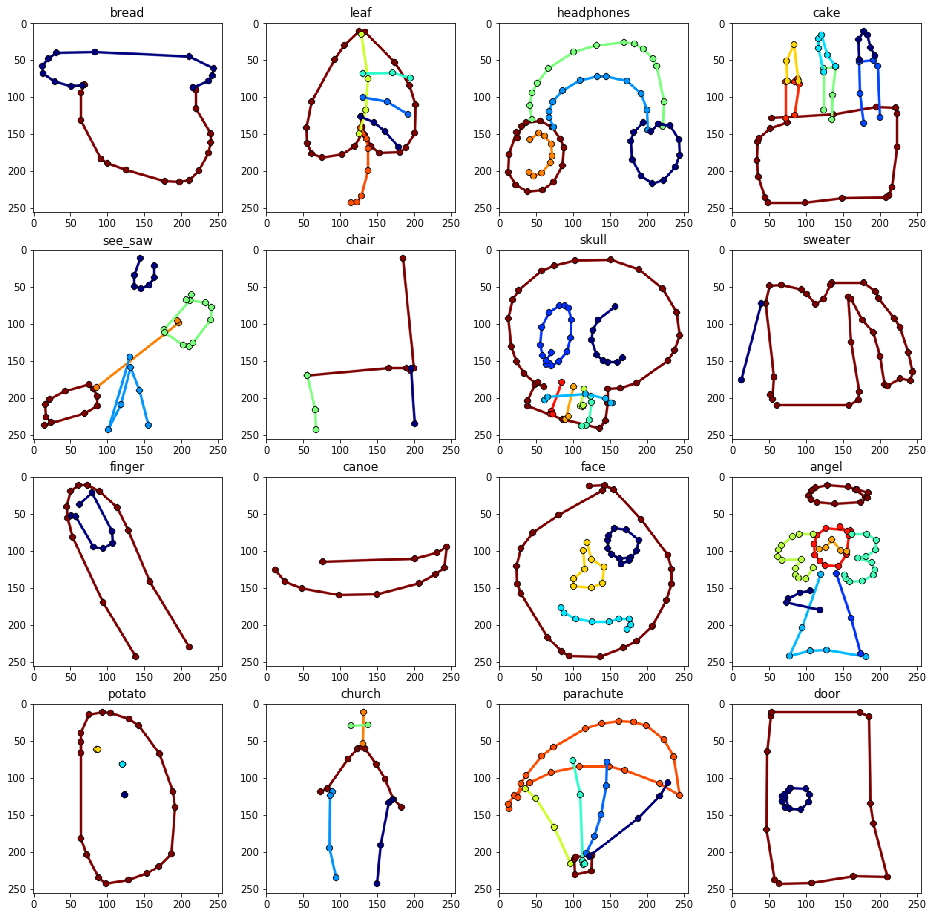

In [19]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    index= np.random.randint(len(dataset))
    stroke, label, cache = dataset[index]
    overlay = draw_point_to_overlay(cache.point)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(CLASS_NAME[label])
    plt.imshow(overlay)
plt.show()

# LSTM to Parse Strokes
The model we tested is

![Suggested Model](https://www.tensorflow.org/versions/master/images/quickdraw_model.png)

For each 1 dim convolutional net, we use ResNet model which consists of Conv1d, BatchNorm1d and ReLU. 

Then followed by 2 LSTM layers with dropout = 0.1 and a linear layer.

In [6]:
class recurrent_net(nn.Module):
    
    def __init__(self,num_class=340): #number of classes 340 classes
        super(recurrent_net, self).__init__()
        
        self.encoder1 = nn.Sequential(
            nn.Conv1d(3,48, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm1d(48), 
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(48,64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm1d(64), 
            nn.ReLU(inplace=True),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(64,128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128), 
            nn.ReLU(inplace=True),
        )
        self.lstm = nn.LSTM(128, 256, num_layers=2, dropout=0.1, bidirectional=True, batch_first=True)
        self.logit = nn.Linear(1024, num_class)
        
    def forward(self, x):
        batch_size, T, dim = x.shape
        
        x = x.permute(0,2,1)
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = x.permute(0,2,1)
        
        y, (h,c) = self.lstm(x)
        z = h.permute(1,0,2).contiguous().view(batch_size,-1) #hidden (bi direction)
        
        logit = self.logit(z)
        return logit
            

In [7]:
net = recurrent_net(num_class=len(CLASS_NAME)).to(device)

# Train

batch size is set to 680 which averages to see 2 doodles per class each batch. The iteration is 15000 to cover the dataset. For every iteration, the batch picked randomly. It uses Adam Optimizer with starting learning rate of 5e-4 which we dived by 1.25 every 5 epochs.

The loss is printed every 500 batches. The model is saved after every epoch. The training runs for 8 epochs. 


# Data  Preparation

Data padding for the length of points to fit into the model. 
Max length is set to be 250 due to the following distribution histogram where most of the pictures has below 250 points and those with large number of points are shown to be very noisy pictures.

In [ ]:
batch_size = 680
my_lr = 5e-4
criterion = nn.CrossEntropyLoss()
start=time.time()
for epoch in range(8):
    
    if epoch >0 and epoch%5==0:
        my_lr = my_lr/1.25
    
    ## optimiser ----------------------------------
    optimizer = torch.optim.Adam( net.parameters(),lr=my_lr)
    
    running_loss =0
    batch_count =0
    
    for iter in range(1,15000):
        
        #set the gradients to zero 
        optimizer.zero_grad()
        
        indices=torch.LongTensor(batch_size).random_(0, 10200000) #170000) #
        minibatch_data=[]
        minibatch_label=[]
        length = np.array([len(dataset[i][0]) for i in indices])
                           
        for i in indices:
            minibatch_data.append(dataset[i][0])
            minibatch_label.append(dataset[i][1])
        
        length_max = 250 #manually set according to justification above
        
        dim = len(dataset[i][0][0])
        pack = np.zeros((batch_size, length_max, dim), np.float32)


        for b in range(batch_size):
            if(len(minibatch_data[b])<=length_max):
                pack[b, 0:length[b]] = minibatch_data[b]
            else:
                pack[b] = minibatch_data[b][0:length_max]
                
        minibatch_data = torch.from_numpy(pack).float()

        if minibatch_label[0] is not None:
            minibatch_label = np.array(minibatch_label)
            minibatch_label = torch.from_numpy(minibatch_label).long()

        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        scores = net(minibatch_data)
        loss= criterion(scores, minibatch_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_count +=1
        if(batch_count >0 and batch_count%500==0):   
            total_loss = running_loss/ batch_count
            elapsed = time.time()-start
            print('')
            print("batch_print")
            print(total_loss)
            print('epoch=',epoch, '\t time=', elapsed,'\t lr=', my_lr, '\t exp(loss)=',  math.exp(total_loss))
            
    
    total_loss = running_loss/ batch_count
    elapsed = time.time()-start
    
    torch.save(net.state_dict(), 'trained_net_dropout_lstm2.pt')
    print('')
    print("epoch print")
    print(total_loss)
    print('epoch=',epoch, '\t time=', elapsed,'\t lr=', my_lr, '\t exp(loss)=',  math.exp(total_loss))

# Train Outputs

1.0537070644220532

epoch= 0 	 time= 14523.583482027054 	 lr= 0.0005 	 exp(loss)= 2.8682642745268234

0.5991254675502785

epoch= 1 	 time= 29045.361045837402 	 lr= 0.0005 	 exp(loss)= 1.820525994953856

0.5289665281939517

epoch= 2 	 time= 43589.65418076515 	 lr= 0.0005 	 exp(loss)= 1.6971774169489353

0.4917397078664885

epoch= 3 	 time= 58119.795632600784 	 lr= 0.0005 	 exp(loss)= 1.6351584449275507


0.4682031729847791

epoch= 4 	 time= 72664.70355653763 	 lr= 0.0005 	 exp(loss)= 1.597121861740985


0.4402794296129186

epoch= 5 	 time= 87198.27683281898 	 lr= 0.0004 	 exp(loss)= 1.5531411515124223


0.4276505317502963

epoch= 6 	 time= 101756.2373380661 	 lr= 0.0004 	 exp(loss)= 1.533650025315815


0.41640568397483696

epoch= 7 	 time= 116300.68365287781 	 lr= 0.0004 	 exp(loss)= 1.5165009642339815

In [ ]:
torch.save(net.state_dict(), 'trained_net_dropout_lstm2.pt')

In [8]:
net.load_state_dict(torch.load('trained_net_dropout_lstm2.pt'))

# Validation

Load the dataset and plot the doodles

In [9]:
test_dataset = DoodleDataset('valid',augment=null_stroke_augment)
print(len(test_dataset))


3400000


D:\CE7454\RNN Train\imageUtils.py:86: RuntimeWarning: invalid value encountered in true_divide
  colors = plt.cm.jet(np.arange(0,T)/(T-1))
C:\Users\Wai Yan\AppData\Local\conda\conda\envs\deeplearn_course\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


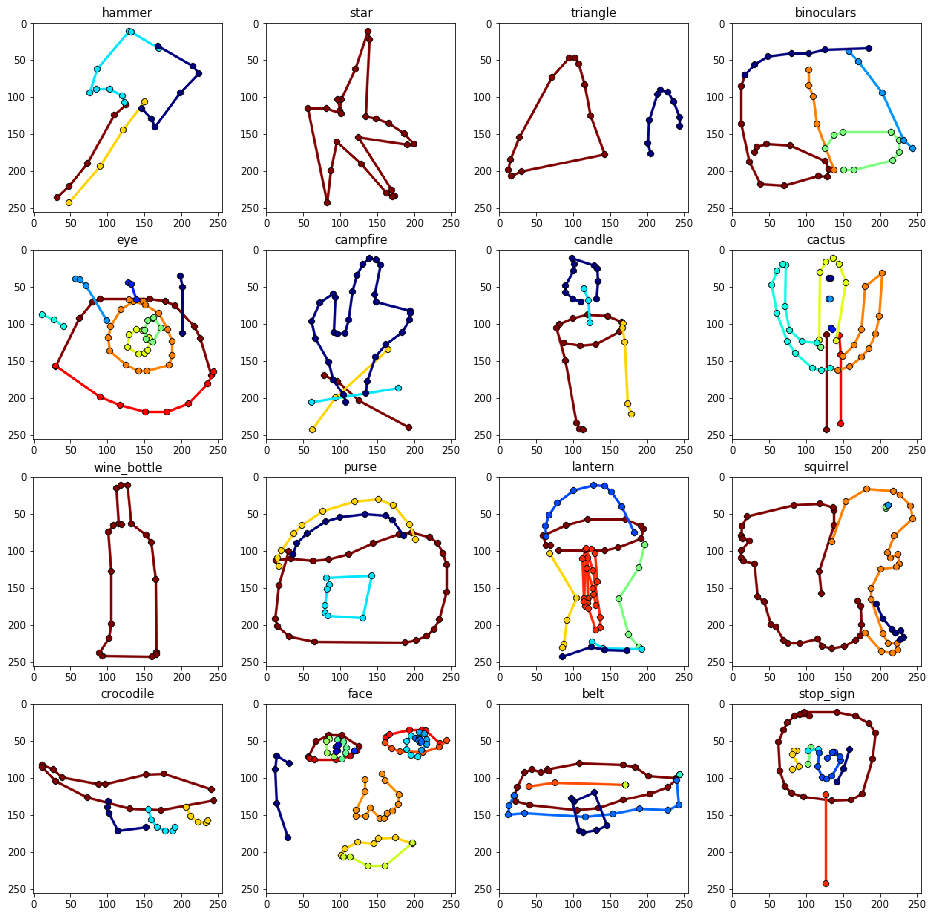

In [10]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    index= np.random.randint(len(test_dataset))
    stroke, label, cache = test_dataset[index]
    overlay = draw_point_to_overlay(cache.point)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(CLASS_NAME[label])
    plt.imshow(overlay)
plt.show()

In [11]:
def get_precision( scores , labels ):

    bs=scores.size(0)
    predicted_labels = np.argsort(-scores,1)[:,:3] #scores.argmax(dim=1)
    predicted_labels = predicted_labels.to(device)
    num_matches = 0
    for i in range(0, len(labels)):
        if(labels[i]==predicted_labels[i][0]):
            num_matches += 1
        elif(labels[i]==predicted_labels[i][1]):
            num_matches += 0.5
        elif(labels[i]==predicted_labels[i][2]):
            num_matches +=0.33
    #indicator = (predicted_labels == labels)
    #num_matches=indicator.sum()
    return num_matches/bs  

In [253]:
batch_size= 100
running_error=0
num_batch = 340
for iter in range(1,num_batch):
    indices=torch.LongTensor(batch_size).random_(0,len(test_dataset))
    minibatch_test_data=[]
    minibatch_test_label=[]
    length = np.array([len(test_dataset[i][0]) for i in indices])
    for i in indices:
        minibatch_test_data.append(test_dataset[i][0])
        minibatch_test_label.append(test_dataset[i][1])
    

    length_max = 250
    dim = len(test_dataset[i][0][0])
    pack = np.zeros((batch_size, length_max, dim), np.float32)
    
    for b in range(batch_size):
        if(len(minibatch_test_data[b])<=length_max):
            pack[b, 0:length[b]] = minibatch_test_data[b]
        else:
            pack[b] = minibatch_test_data[b][0:length_max]
                
    minibatch_test_data = torch.from_numpy(pack).float()

    if minibatch_test_label[0] is not None:
        minibatch_test_label = np.array(minibatch_test_label)
        minibatch_test_label = torch.from_numpy(minibatch_test_label).long()

    minibatch_test_data = minibatch_test_data.to(device)
    minibatch_test_label = minibatch_test_label.to(device)

    scores = net(minibatch_test_data)
    scores = F.softmax(scores, dim=1)
    running_error  += get_precision(scores.detach(),minibatch_test_label) #.item()
    
    
total_error = running_error/(num_batch-1)

print( 'precision on validation set =', total_error*100 ,'percent')

precision on validation set = 91.45666666666669 percent


### Check distribution of number of points on each doodle

The histogram depicts that most of the doodles contains less than 250 points in each doodle. 

Thus, we set the padding size (length_max) to 250.

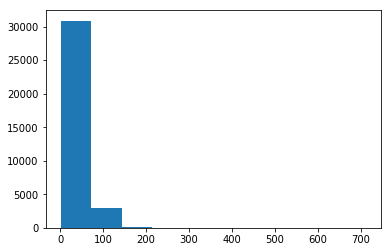

In [142]:
stroke_length= np.array([len(test_dataset[i][0]) for i in range(0,len(test_dataset),100)]) 
plt.hist(stroke_length)
plt.show()

Now, we will check what the outliers look like.

In [170]:
outliers = np.argsort(-stroke_length,0)[:8] 
#itemindex = np.where(stroke_length==710)[0]
print(outliers)

[ 3575 14788 15752 15755 27264  3537 15748  3573]


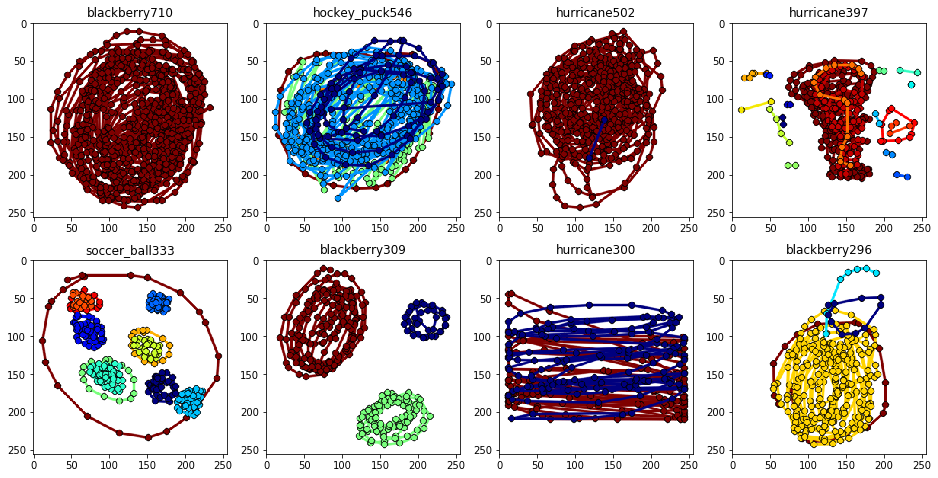

In [210]:
fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    index= outliers[i-1]*100
    stroke, label, cache = test_dataset[index]
    overlay = draw_point_to_overlay(cache.point)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(CLASS_NAME[label]+ str(len(stroke)))
    plt.imshow(overlay)
plt.show()

We tried downsampling by 3. The results are as shown.

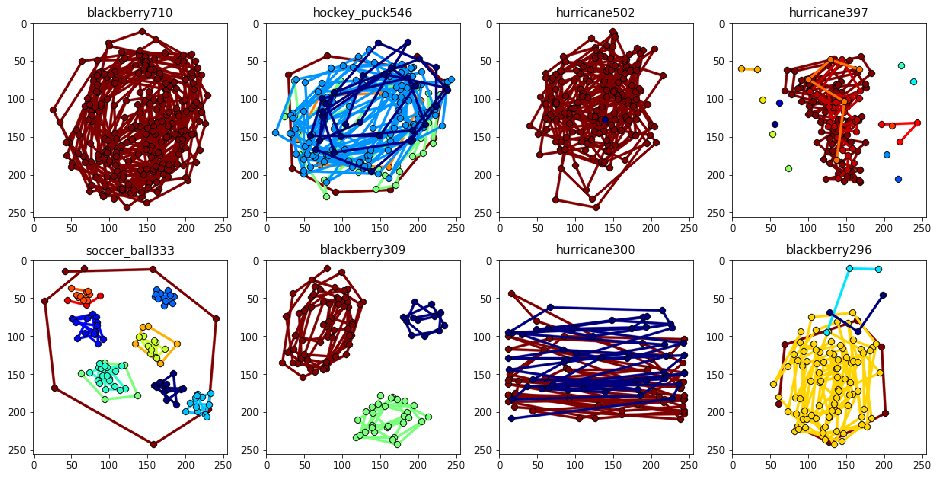

In [211]:
fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    index= outliers[i-1]*100
    stroke, label, cache = test_dataset[index]
    point = np.array([cache.point[i].tolist() for i in range(0, len(cache.point), 3) ])
    overlay = draw_point_to_overlay(point)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(CLASS_NAME[label]+ str(len(stroke)))
    plt.imshow(overlay)
plt.show()

We tried to cut off first 0 to 250 points/strokes. 

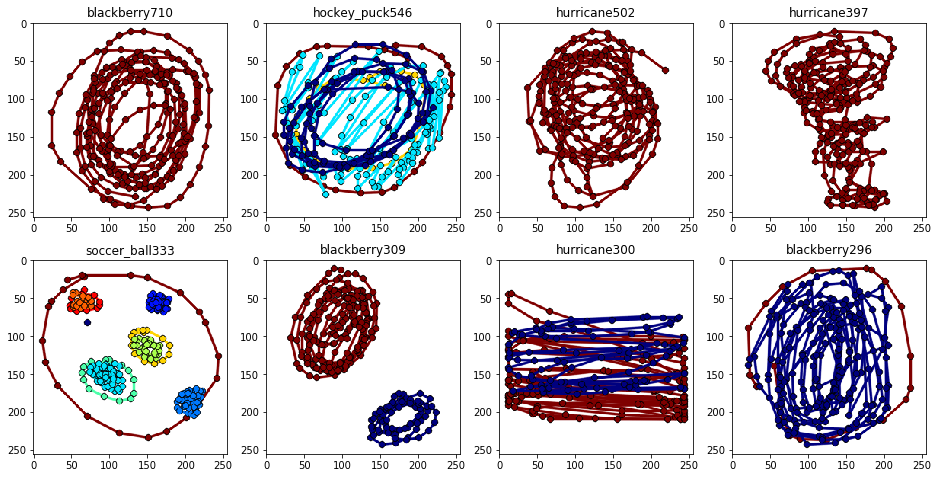

In [212]:
fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    index= outliers[i-1]*100
    stroke, label, cache = test_dataset[index]
    overlay = draw_point_to_overlay(cache.point[:250])
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(CLASS_NAME[label]+ str(len(stroke)))
    plt.imshow(overlay)
plt.show()

Hence, according the methods, rather than downsampling, the doodles are more recognizable if we just cut the first 250 points/strokes. 

# Submission

In [12]:
def prob_to_csv(prob, key_id, csv_file):
    prob_list = prob.data.tolist();
    top = np.argsort(-prob,1)[:,:10]
    top_list =  np.sort(-prob,1)[:,:10] 
    top_list = np.multiply(top_list,-1)
        
    df = pd.DataFrame({ 'key_id' : key_id , 'scores' : top_list.data.tolist(), 'labels': top.data.tolist()}).astype(str)
    #print(df)
    df.to_csv(csv_file, mode='a', header=False, index=False, columns=['key_id', 'scores','labels'], compression='')

In [107]:
def prob_to_csv_decimals(prob, key_id, csv_file):
    prob_list = prob.data.tolist();
    for i in range(0,340):
        prob_list[i]= [round (x,7) for x in prob_list[i]]
        #print("sum =" , sum(x > 0 for x in prob_list[i]))
        
    df = pd.DataFrame({ 'key_id' : key_id , 'scores' : prob_list}).astype(str)
    #print(df)
    df.to_csv(csv_file, mode='a', header=False, index=False, columns=['key_id', 'scores'], compression='')

In [28]:
def prob_to_csv_submit(prob, key_id, csv_file):
    
    top = np.argsort(-prob,1)[:,:3]
    word = []
    for (t0,t1,t2) in top:
        word.append(
            CLASS_NAME[t0] + ' ' + \
            CLASS_NAME[t1] + ' ' + \
            CLASS_NAME[t2]
        )
    df = pd.DataFrame({ 'key_id' : key_id , 'word' : word}).astype(str)
    #print(df)
    df.to_csv(csv_file, mode='a',  header=False, index=False, columns=['key_id', 'word'], compression='')

### Generate submission file to submit to kaggle

In [29]:
predict_dataset = DoodleDataset('test',augment=null_stroke_augment)
predict_dataset_length = len(predict_dataset)
print(predict_dataset_length)

112199


In [46]:
for i in range(0,len(predict_dataset)):
    predict_data=[]
    predict_key_id=[]
    predict_data.append(predict_dataset[i][0])
    length = np.array([len(predict_data[i]) for i in range(len(predict_data))])
    length_max = 250
    dim = len(predict_data[0][0])
    pack = np.zeros((len(predict_data), length_max, dim), np.float32)
    if(len(predict_data[0])<=length_max):
        pack[0, 0:len(predict_data[0])] = predict_data[0]
    else:
        pack[0] = predict_data[0][0:length_max]
    predict_data = torch.from_numpy(pack).float()

    predict_data = predict_data.to(device)

    scores = net(predict_data)
    scores = F.softmax(scores, dim=1)
    prob_to_csv_submit(scores.detach(), predict_dataset.get_test_key_id()[i], 'submission_test_lstm2.csv.');

KeyboardInterrupt: 

### Print out the validation prediction file

In [13]:
batch_size= 340
running_error=0
num_batch = 10000
batch_count = 0
for iter in range(1,num_batch):
    indices= [(i+ (batch_count*batch_size)) for i in range(0,batch_size)] #torch.LongTensor(batch_size).random_(0,len(test_dataset))
    minibatch_test_data=[]
    minibatch_test_label=[]
    key_id = []
    length = np.array([len(test_dataset[i][0]) for i in indices])
    for i in indices:
        minibatch_test_data.append(test_dataset[i][0])
        minibatch_test_label.append(test_dataset[i][1])
        key_id.append(test_dataset.get_key_id(i))
    

    length_max = 250
    dim = len(test_dataset[i][0][0])
    pack = np.zeros((batch_size, length_max, dim), np.float32)
    
    for b in range(batch_size):
        if(len(minibatch_test_data[b])<=length_max):
            pack[b, 0:length[b]] = minibatch_test_data[b]
        else:
            pack[b] = minibatch_test_data[b][0:length_max]
                
    minibatch_test_data = torch.from_numpy(pack).float()

    if minibatch_test_label[0] is not None:
        minibatch_test_label = np.array(minibatch_test_label)
        minibatch_test_label = torch.from_numpy(minibatch_test_label).long()

    minibatch_test_data = minibatch_test_data.to(device)
    minibatch_test_label = minibatch_test_label.to(device)

    scores = net(minibatch_test_data)
    scores = F.softmax(scores, dim=1)
    running_error  += get_precision(scores.detach(),minibatch_test_label) #.item()
    prob_to_csv(scores.detach(), key_id , 'validation_scores_topten.csv.');
    batch_count+= 1
    if(batch_count >0 and batch_count%500==0):   
        print('')
        print('batch print = ', batch_count)
        total_error = running_error/(batch_count-1)
        print( 'precision on validation set =', total_error*100 ,'percent')
    
total_error = running_error/(num_batch-1)

print( 'precision on validation set =', total_error*100 ,'percent')


batch print =  500
precision on validation set = 81.85989626311442 percent

batch print =  1000
precision on validation set = 79.20742507213086 percent

batch print =  1500
precision on validation set = 79.07707295059438 percent

batch print =  2000
precision on validation set = 79.34658799988212 percent

batch print =  2500
precision on validation set = 79.12707082833131 percent

batch print =  3000
precision on validation set = 78.72789066943892 percent

batch print =  3500
precision on validation set = 79.13735184842733 percent

batch print =  4000
precision on validation set = 78.95885147757537 percent

batch print =  4500
precision on validation set = 79.37708641135944 percent

batch print =  5000
precision on validation set = 79.06560312062415 percent

batch print =  5500
precision on validation set = 79.08226843383291 percent

batch print =  6000
precision on validation set = 78.87851602718084 percent

batch print =  6500
precision on validation set = 78.70086031335124 percent


# Print out test predictions

In [14]:
test_dataset = DoodleDataset('test_local',augment=null_stroke_augment)
print(len(test_dataset))


3400000


In [17]:
batch_size= 340
running_error=0
num_batch = 10000
batch_count = 0
for iter in range(1,num_batch):
    indices=[(i+ (batch_count*batch_size)) for i in range(0,batch_size)] #torch.LongTensor(batch_size).random_(0,len(test_dataset))
    minibatch_test_data=[]
    minibatch_test_label=[]
    key_id = []
    length = np.array([len(test_dataset[i][0]) for i in indices])
    for i in indices:
        minibatch_test_data.append(test_dataset[i][0])
        minibatch_test_label.append(test_dataset[i][1])
        key_id.append(test_dataset.get_key_id(i))
    

    length_max = 250
    dim = len(test_dataset[i][0][0])
    pack = np.zeros((batch_size, length_max, dim), np.float32)
    
    for b in range(batch_size):
        if(len(minibatch_test_data[b])<=length_max):
            pack[b, 0:length[b]] = minibatch_test_data[b]
        else:
            pack[b] = minibatch_test_data[b][0:length_max]
                
    minibatch_test_data = torch.from_numpy(pack).float()

    if minibatch_test_label[0] is not None:
        minibatch_test_label = np.array(minibatch_test_label)
        minibatch_test_label = torch.from_numpy(minibatch_test_label).long()

    minibatch_test_data = minibatch_test_data.to(device)
    minibatch_test_label = minibatch_test_label.to(device)

    scores = net(minibatch_test_data)
    scores = F.softmax(scores, dim=1)
    running_error  += get_precision(scores.detach(),minibatch_test_label) #.item()
    prob_to_csv(scores.detach(), key_id , 'test_scores_topten.csv.');
    batch_count+= 1
    if(batch_count >0 and batch_count%500==0):   
        print('')
        print('batch print = ', batch_count)
        total_error = running_error/(batch_count-1)
        print( 'precision on test set =', total_error*100 ,'percent')
    
total_error = running_error/(num_batch-1)

print( 'precision on test set =', total_error*100 ,'percent')


batch print =  500
precision on test set = 81.64387598726866 percent

batch print =  1000
precision on test set = 79.03741388447273 percent

batch print =  1500
precision on test set = 78.93802535023352 percent

batch print =  2000
precision on test set = 79.2438498661096 percent

batch print =  2500
precision on test set = 79.05087211355143 percent

batch print =  3000
precision on test set = 78.65423474491507 percent

batch print =  3500
precision on test set = 79.0849217423467 percent

batch print =  4000
precision on test set = 78.9211486695204 percent

batch print =  4500
precision on test set = 79.31278846279591 percent

batch print =  5000
precision on test set = 79.00936893261034 percent

batch print =  5500
precision on test set = 79.02285067873335 percent

batch print =  6000
precision on test set = 78.80970750026998 percent

batch print =  6500
precision on test set = 78.62878406632719 percent

batch print =  7000
precision on test set = 78.36197313902007 percent

batch pri